In [1]:
import sys
import numpy as np
import math
import ceo
import matplotlib.pyplot as plt
import IPython
%matplotlib inline
import scipy.io as sio
import os.path
import datetime

In [2]:
from FDSP_control_params import *

pupil sampling: 361 pixel
number of SH SAs across pupil: 30
number of SH pixels per SA: 12


In [3]:
## GENERIC STUFF:
tid = ceo.StopWatch()
VISU=True

## INITIALIZING CEO OBJECTS:

In [4]:
# Telescope
gmt = ceo.GMT_MX(D, nPx, M1_radial_order=M1_radial_order, M2_radial_order=M2_radial_order)

In [5]:
simul_turb=False
simul_FDSP_control = True
simul_PS_control = True
simul_SPS=True

In [6]:
# Turbulence parameters:
if simul_turb == True:
    atm = ceo.JGmtAtmosphere(jsonfile=atm_fname)
    r0 = atm.r0
    L0 = atm.L0

pupil sampling: 361 pixel
number of SH SAs across pupil: 30
number of SH pixels per SA: 12
SH Pixel scale: 0.078arcsec
SH Field of view: 2.019arcsec


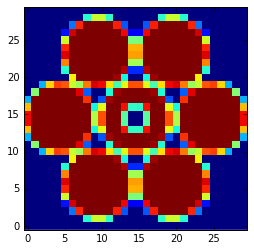

In [7]:
# ON-AXIS AO SH WFS:
p = D/(nPx-1)
if simul_SH == True:
    d = D/nLenslet
    wfs = ceo.ShackHartmann(nLenslet, n, d, N_PX_IMAGE=2*(n+1), N_GS=1)
    gs = ceo.Source("R",zenith=0.,azimuth=0.,
                    rays_box_size=D, rays_box_sampling=nPx, rays_origin=[0.0,0.0,25])

    # Calibrate SH (valid SAs, slope null vector)
    gs.reset()
    gmt.reset()
    gmt.propagate(gs)
    wfs.calibrate(gs,sh_thr)

    sh_fov = wfs.pixel_scale_arcsec*wfs.N_PX_IMAGE/wfs.BIN_IMAGE

    if VISU == True:
        plt.imshow(wfs.flux.host(shape=(nLenslet,nLenslet)).T,interpolation='none', origin='lower')

    print "pupil sampling: %d pixel"%nPx
    print "number of SH SAs across pupil: %d"%nLenslet
    print "number of SH pixels per SA: %d"%n
    print "SH Pixel scale: %.3farcsec"%(wfs.pixel_scale_arcsec)
    print "SH Field of view: %.3farcsec"%(sh_fov)    

Number of SPS GS photons/s/m^2: 81780.5
Number of expected SPS GS photons [ph/s/m^2]: 81828.7
Size of DFS detector mask [pix]: 20


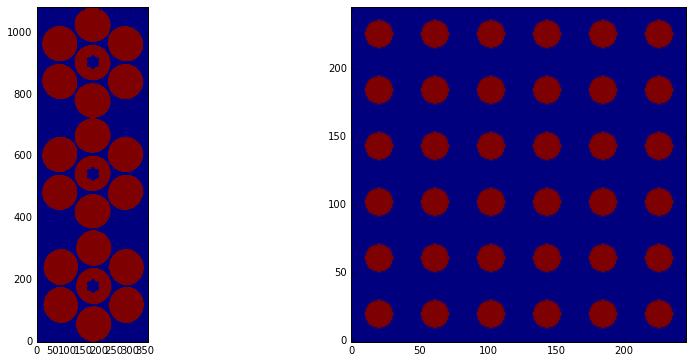

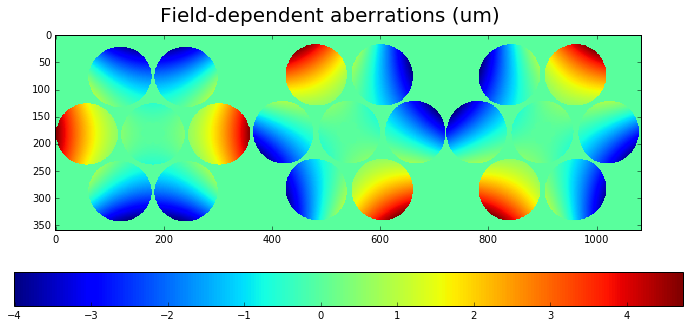

In [8]:
# SPS GUIDE STARS AND SENSORS:
if simul_SPS==True:

    zenith_angle_ps  = np.ones(N_GS_PS)*alpha_ps*math.pi/180/3600 # in radians
    azimuth_angle_ps = np.arange(N_GS_PS)*360.0/N_GS_PS # in degrees
    gsps = ceo.Source(band, magnitude=mag,
                      zenith=zenith_angle_ps,azimuth=azimuth_angle_ps*math.pi/180,
                      rays_box_size=D,rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])

    print('Number of SPS GS photons/s/m^2: %.1f'%(gsps.nPhoton/N_GS_PS))
    print('Number of expected SPS GS photons [ph/s/m^2]: %.1f'%(e0*10**(-0.4*mag)/PupilArea))

    if SPStype == 'ideal':
        ps = ceo.IdealSegmentPistonSensor(gmt, gsps)
    elif SPStype == 'DFS':
        ps = ceo.DispersedFringeSensor(gmt.M1, gsps, dispersion=sps_dispersion,
                                       field_of_view=sps_fov, nyquist_factor=nyquist_factor)
        ps.lobe_detection = lobe_detection
        ps.camera.photoelectron_gain = throughput
        if sps_mask_size > 0: ps.init_detector_mask(sps_mask_size)

    # Calibrate DFS
    gmt.reset()
    gsps.reset()
    if SPStype == 'DFS':
        ps.INIT_ALL_ATTRIBUTES = False
        ps.calibrate(gsps,gmt)

    if VISU == True and SPStype == 'DFS':
        fig1, (ax1,ax2) = plt.subplots(ncols=2)
        fig1.set_size_inches((14,6))
        ax1.imshow(gsps.wavefront.amplitude.host().reshape((nPx*N_GS_PS,nPx)), origin='lower')
        ax2.imshow(ps.fft_mask.f.host().reshape((ps.camera.N_PX_FRAME,ps.camera.N_PX_FRAME)),
                   origin='lower')

    # Calibrate SPS reference vector (corresponding to field-dependent aberrations)
    gmt.reset()
    ps.reset()
    gsps.reset()
    gmt.propagate(gsps)
    ph_fda = gsps.phase.host(units='micron').T
    SPSmeas_ref = ps.piston(gsps, segment='edge').ravel()
    
    if eval_perf_sps==True:
        seg_pist_sps_ref = gsps.piston(where='segments', units_exponent=-9)

    if VISU == True:
        fig2, ax = plt.subplots()
        fig2.set_size_inches(20,5)
        fig2.suptitle('Field-dependent aberrations (um)', fontsize=20)
        imm = ax.imshow(ph_fda, interpolation='None')
        fig2.colorbar(imm, orientation='horizontal', shrink=0.6)

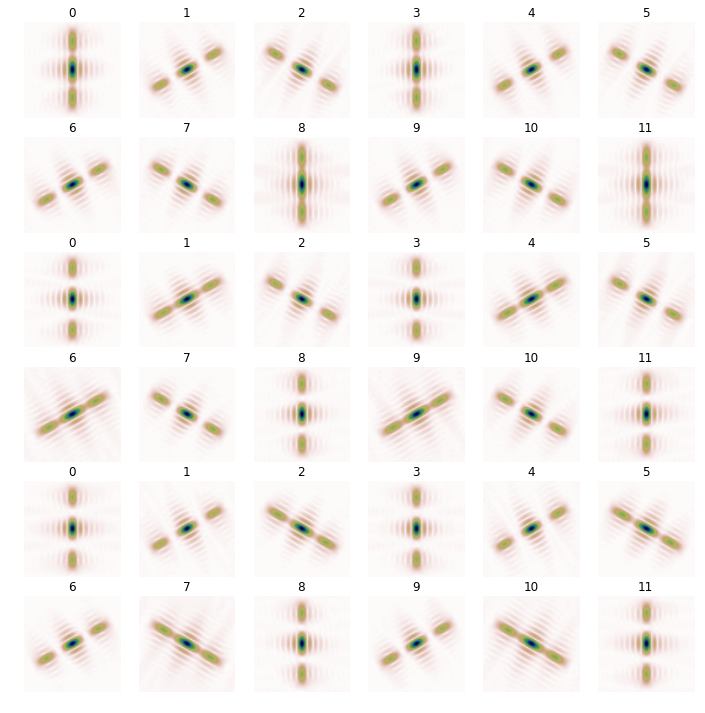

In [9]:
if simul_SPS==True:
    # Show DFS reference imagettes
    def show_sps_imagettes():
        dataCube = ps.get_data_cube(data_type='fftlet')

        fig, ax = plt.subplots(ps.camera.N_SIDE_LENSLET,ps.camera.N_SIDE_LENSLET)
        fig.set_size_inches((12,12))
        xvec = np.arange(0,ps.camera.N_PX_IMAGE,10)
        for k in range(gsps.N_SRC*12):
            (ax.ravel())[k].imshow(np.sqrt(dataCube[:,:,k]), cmap=plt.cm.gist_earth_r, origin='lower')
            (ax.ravel())[k].autoscale(False)
            if ps.INIT_ALL_ATTRIBUTES == True:
                (ax.ravel())[k].plot(xvec, xvec*ps.pl_m[k] + ps.pl_b[k], 'y')
                (ax.ravel())[k].plot(xvec, xvec*ps.pp_m[k] + ps.pp_b[k], 'y--')
                for pp in range(3):
                    c1 = plt.Circle((ps.blob_data[k,pp,1], ps.blob_data[k,pp,0]),radius=np.sqrt(2)*ps.blob_data[k,pp,2],
                                color='b', fill=False)
                    (ax.ravel())[k].add_patch(c1)
            (ax.ravel())[k].set_title('%d'%(k%12), fontsize=12)

        for k in range(ps.camera.N_SIDE_LENSLET**2):
            (ax.ravel())[k].axis('off')

    if VISU == True and SPStype == 'DFS':
        show_sps_imagettes()

--> WF RMS on-axis: 0.79 nm wf RMS


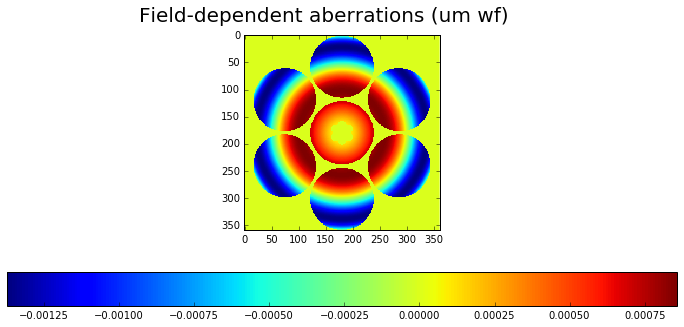

In [10]:
## PERFORMANCE EVALUATION

# Initialize on-axis star for performance evaluation
ongs = ceo.Source("R", zenith=0., azimuth=0.,
              rays_box_size=D, rays_box_sampling=nPx, rays_origin=[0.0,0.0,25])
gmt.reset()
ongs.reset()
gmt.propagate(ongs)
ph_fda_on = ongs.phase.host(units='micron')
on_rms0 = ongs.wavefront.rms()*1e9
print '--> WF RMS on-axis: %3.2f nm wf RMS'%on_rms0
seg_pist_onaxis_ref = ongs.piston(where='segments', units_exponent=-9)

if VISU == True:
    fig, ax = plt.subplots()
    fig.set_size_inches(20,5)
    fig.suptitle('Field-dependent aberrations (um wf)', fontsize=20)
    imm = ax.imshow(ph_fda_on, interpolation='None')
    fig.colorbar(imm, orientation='horizontal', shrink=0.6)
    
# On-axis projection of segment shapes onto Zernikes
if eval_perf_modal==True:
    proj_radial_order= np.max( (8, gmt.M1.zernike.max_n+1, gmt.M2.zernike.max_n+1) )
    Zobj = ceo.ZernikeS(proj_radial_order)
    Zobj.fitting_init(ongs)

## INTERACTION MATRICES CALIBRATION

___ M2 ___
Segment #:1 2 3 4 5 6 7 
------------
AO SH WFS - M2 segment TT Rec:
(14, 1184)
___ M2 ___
Segment #0: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 
Segment #1: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 
Segment #2: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 
Segment #3: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 
Segment #4: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 
Segment #5: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 
Segment #6: 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 

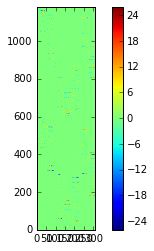

In [11]:
# Calibrate AO SH WFS - M2 IMs
if simul_SH == True:

    #----- M2 segment TT Interaction Matrix and Reconstructor
    TTstroke = 25e-3 #arcsec
    D_M2_TT = gmt.calibrate(wfs, gs, mirror="M2", mode="segment tip-tilt",
                            stroke=TTstroke*math.pi/180/3600)
    R_M2_TT = np.linalg.pinv(D_M2_TT)
    print 'AO SH WFS - M2 segment TT Rec:'
    print R_M2_TT.shape

    #----- M2 segment Zernikes Interaction Matrix and Reconstructor
    Zstroke = 20e-9 #m rms
    z_first_mode = 1  # to remove Tip/Tilt
    D_M2_Z = gmt.calibrate(wfs, gs, mirror="M2", mode="zernike", stroke=Zstroke,
                           first_mode=z_first_mode)
    nzernall = (D_M2_Z.shape)[1]  ## number of zernike DoFs calibrated
    R_M2_Z = np.linalg.pinv(D_M2_Z)
    print 'AO SH WFS - M2 Segment Zernike IM:'
    print D_M2_Z.shape
    print 'Condition number: %f'%np.linalg.cond(D_M2_Z)

    if VISU == True:
        plt.imshow(D_M2_Z, origin='lower')
        plt.colorbar()

In [12]:
# Calibrate AO SH WFS - M2 global TT Interaction Matrix and Reconstructor
if simul_SH == True:
    TTstroke = 25e-3 #arcsec
    gmt.reset()
    D_M2_gTT = gmt.calibrate(wfs, gs, mirror="M2", mode="global tip-tilt", stroke=TTstroke*math.pi/180/3600)
    R_M2_gTT = np.linalg.pinv(D_M2_gTT)
    print 'AO SH WFS - M2 segment TT Rec:'
    print R_M2_gTT.shape
    print 'Condition number: %f'%np.linalg.cond(D_M2_gTT)

___ M2 ___
------------
AO SH WFS - M2 segment TT Rec:
(2, 1184)
Condition number: 1.000209


Merged SH WFS - global/local TT IM:
(16, 1184)


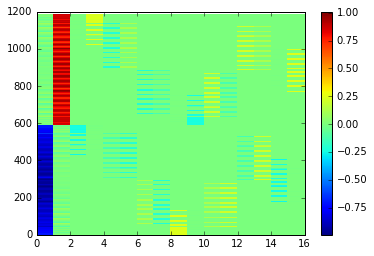

In [80]:
# Merge AO SH WFS - M2 global AND segment TTs in a single IM and REC
D_M2_TTm = np.concatenate((D_M2_gTT, D_M2_TT), axis=1)
R_M2_TTm = np.linalg.pinv(D_M2_TTm)#, rcond=2e-2)
print 'Merged SH WFS - global/local TT IM:'
print R_M2_TTm.shape

if VISU == True:
    plt.pcolor(D_M2_TTm)
    plt.colorbar()

Condition number: 145.524077


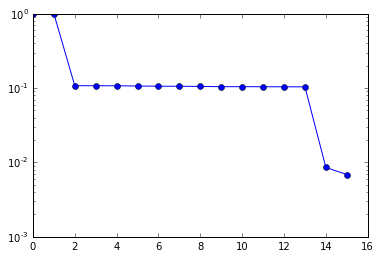

In [31]:
print 'Condition number: %f'%np.linalg.cond(D_M2_TTm)
UU, ss, VV = np.linalg.svd(D_M2_TTm, full_matrices=False)
plt.semilogy(ss/np.max(ss), 'o-')

___ M1 ___
Segment #:1 2 3 4 5 6 
------------
SPS - M1 Segment Piston Rec:
(6, 36)


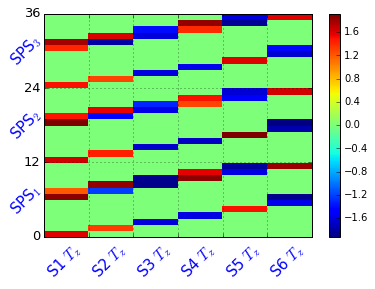

In [14]:
# Calibrate Segment Piston Sensor Interaction Matrix and Reconstructor
if simul_PS_control==True:
    PSstroke = 200e-9 #m

    if PS_CL_calib==False:
        D_M1_PS = gmt.calibrate(ps, gsps, mirror="M1", mode="segment piston",
                            stroke=PSstroke, segment='edge')
    else:
        D_M1_PS = gmt.calibrate(ps, gsps, mirror="M1", mode="segment piston", stroke=PSstroke,
                segment='edge', cl_wfs=wfs, cl_gs=gs, cl_recmat=R_M2_Z, closed_loop_calib=True)

    R_M1_PS = np.linalg.pinv(D_M1_PS)
    print 'SPS - M1 Segment Piston Rec:'
    print R_M1_PS.shape

    if VISU == True:
        fig, ax = plt.subplots()
        fig.set_size_inches(6,4)
        imm = ax.pcolor(D_M1_PS*1e-6)  #in displaced pixels per micron
        ax.grid()
        ax.set_ylim([0,36])
        ax.set_xticklabels(['S1 $T_z$','S2 $T_z$','S3 $T_z$','S4 $T_z$','S5 $T_z$','S6 $T_z$'], ha='left',
                           fontsize=15, rotation=45, color='b')
        ax.set_yticks([0,12,24,36])
        ax.tick_params(axis='y', labelsize=13)
        ax.text(-0.4,6,'SPS$_1$', rotation=45, ha='center', va='center', fontsize=15, color='b')
        ax.text(-0.4,18,'SPS$_2$', rotation=45, ha='center', va='center', fontsize=15, color='b')
        ax.text(-0.4,30,'SPS$_3$', rotation=45, ha='center', va='center', fontsize=15, color='b')
        fig.colorbar(imm)

In [18]:
remove_on_pist = True
CL_calib_modes = 'TT'

___ M1 ___
Segment #:1 2 3 4 5 6 
------------
SPS - M1 Ideal Segment Piston Rec:
(6, 6)
___ M1 ___
Segment #:1 2 3 4 5 6 
------------
SPS - FDSP Rec:
(12, 36)


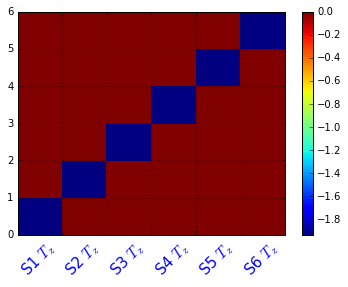

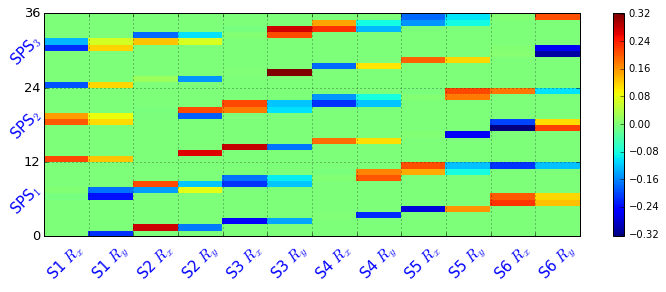

In [19]:
# Calibrate FDSP Interaction Matrix and Reconstructor
if simul_FDSP_control==True:

    # Initialize and Calibrate Ideal on-axis Segment Piston Sensor
    if remove_on_pist==True:
        PSstroke = 200e-9 #m
        onps = ceo.IdealSegmentPistonSensor(gmt, gs)
        D_M1_PSideal = gmt.calibrate(onps, gs, mirror="M1", mode="segment piston",
                                     stroke=PSstroke, segment='full')

        R_M1_PSideal = np.linalg.pinv(D_M1_PSideal)
        print 'SPS - M1 Ideal Segment Piston Rec:'
        print R_M1_PSideal.shape

        gs.reset()
        gmt.reset()
        gmt.propagate(gs)
        onps_signal_ref = onps.piston(gs, segment='full').ravel()[0:6] # reference signal

        if VISU == True:
            fig, ax = plt.subplots()
            fig.set_size_inches(6,4)
            imm = ax.pcolor(D_M1_PSideal)
            ax.grid()
            ax.set_xticklabels(['S1 $T_z$','S2 $T_z$','S3 $T_z$','S4 $T_z$','S5 $T_z$','S6 $T_z$'],
                                ha='left', fontsize=15, rotation=45, color='b')
            fig.colorbar(imm)

    # Calibrate FDSP Interaction Matrix and Reconstructor
    TTstroke = 50e-3 #arcsec

    if CL_calib_modes=='TT':
        R_4calib = R_M2_TT
    elif CL_calib_modes=='zernikes':
        R_4calib = R_M2_Z

    if remove_on_pist == True:
        D_FDSP = gmt.calibrate(ps, gsps, mirror="M1", mode="FDSP", stroke=TTstroke*math.pi/180/3600,
                           segment='edge', cl_wfs=wfs, cl_gs=gs, cl_recmat=R_4calib,
                           idealps=onps, idealps_rec=R_M1_PSideal, idealps_ref=onps_signal_ref,
                           remove_on_pist=remove_on_pist, CL_calib_modes=CL_calib_modes)
    else:
        D_FDSP = gmt.calibrate(ps, gsps, mirror="M1", mode="FDSP", stroke=TTstroke*math.pi/180/3600,
                           segment='edge', cl_wfs=wfs, cl_gs=gs, cl_recmat=R_4calib,
                           remove_on_pist=remove_on_pist, CL_calib_modes=CL_calib_modes)

    R_FDSP = np.linalg.pinv(D_FDSP)
    print 'SPS - FDSP Rec:'
    print R_FDSP.shape

    if VISU == True:
        fig2, ax2 = plt.subplots()
        fig2.set_size_inches(12,4)

        #Rx and Ry are in radians. We want to show IM in microns RMS SURF of tilt
        #We found using DOS that a segment tilt of 47 mas is equivalent to 0.5 microns RMS of tilt on an M1 seg.
        AngleRadians_2_tiltcoeff = 0.5 / (47e-3*math.pi/180/3600) #angle in radians to microns RMS of tilt coeff

        imm = ax2.pcolor(D_FDSP/AngleRadians_2_tiltcoeff)  #in displaced pixels per microns RMS of M1 segment tilt
        ax2.grid()
        ax2.set_ylim([0,36])
        ax2.set_xticks(range(12))
        ax2.set_xticklabels(['S1 $R_x$','S1 $R_y$','S2 $R_x$','S2 $R_y$','S3 $R_x$','S3 $R_y$',
                            'S4 $R_x$','S4 $R_y$','S5 $R_x$','S5 $R_y$','S6 $R_x$','S6 $R_y$'],
                           ha='left', fontsize=15, rotation=45, color='b')
        ax2.set_yticks([0,12,24,36])
        ax2.tick_params(axis='y', labelsize=13)
        ax2.text(-0.4,6,'SPS$_1$', rotation=45, ha='center', va='center', fontsize=15, color='b')
        ax2.text(-0.4,18,'SPS$_2$', rotation=45, ha='center', va='center', fontsize=15, color='b')
        ax2.text(-0.4,30,'SPS$_3$', rotation=45, ha='center', va='center', fontsize=15, color='b')
        fig2.colorbar(imm)

Merged SPS - PISTON Rec:
(18, 36)
PIST Condition number: 2.325375
FDSP Condition number: 2.203139
Merged Condition number: 10.072395


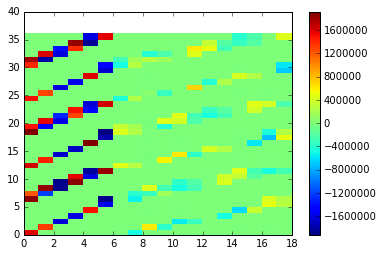

In [20]:
# Combine Interaction Matrices of M1 segment piston AND FDSP.
if simul_PS_control==True and simul_FDSP_control==True:
    D_PIST = np.concatenate((D_M1_PS, D_FDSP), axis=1)
    R_PIST = np.linalg.pinv(D_PIST)
    print 'Merged SPS - PISTON Rec:'
    print R_PIST.shape
    
    print 'PIST Condition number: %f'%np.linalg.cond(D_M1_PS)
    print 'FDSP Condition number: %f'%np.linalg.cond(D_FDSP)
    print 'Merged Condition number: %f'%np.linalg.cond(D_PIST)

    if VISU == True:
        plt.pcolor(D_PIST)
        plt.colorbar()

### INITIAL SCRAMBLE

In [69]:
scramble_tt = False

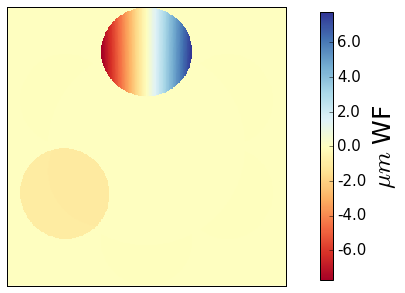

In [81]:
# Reset before starting
if simul_onaxis_AO==True:
    gs.reset()
if simul_SPS==True:
    gsps.reset()
ongs.reset()
gmt.reset()

# Apply a known Tilt to a particular segment on M1
M1RotVecInit = np.array([  #arcsec
            [0,200e-3,0] ,  # 200e-3
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0]], dtype='float32') * math.pi/180/3600

# Apply a known segment piston/translation to a particular segment on M1
M1TrVecInit = np.array([  # meters surf
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,500e-9],
            [0,0,0],
            [0,0,0]], dtype='float32')


# Apply a known Tilt to a particular segment on M2
M2RotVecInit = np.array([  #arcsec
            [0,0,0] ,
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0]], dtype='float32') * math.pi/180/3600

# Apply a known segment piston/translation to a particular segment on M2
M2TrVecInit = np.array([  # meters surf
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0],
            [0,0,0]], dtype='float32')

# Initial Segment TT Scramble
if scramble_tt==True:
    TTscramble = np.float32(np.random.normal(loc=0.0, scale=1, size=12))
    TTscramble *= tt_scramble_rms*(math.pi/180/3600)/np.std(TTscramble)
    TTscramble -= np.mean(TTscramble)
    M1RotVecInit[0:6,0:2] += TTscramble.reshape((6,2))
    print "Initial M1 segment TT scramble RMS [mas]: %0.2f"%(np.std(TTscramble)*ceo.constants.RAD2MAS)
    print "Initial M1 segment TT scramble mean value [mas]: %0.2f"%(np.mean(TTscramble)*ceo.constants.RAD2MAS)

# Initial Segment Piston Scramble
if scramble_pist==True:
    pistscramble = np.float32(np.random.normal(loc=0.0, scale=1, size=7))
    pistscramble *= pist_scramble_rms/np.std(pistscramble)
    pistscramble -= np.mean(pistscramble)
    pistscramble -= pistscramble[6]
    M1TrVecInit[:,2] += pistscramble
    print "Initial segment piston scramble RMS [micron]: %0.2f"%(np.std(pistscramble)*1e6)
    print "Initial segment piston scramble mean value [micron]: %0.2f"%(np.mean(pistscramble)*1e6)

### Set GMT M1 and M2 rigid-body scrambles
for idx in range(7): gmt.M1.update(origin=M1TrVecInit[idx,:].tolist(),
                                   euler_angles=M1RotVecInit[idx,:].tolist(),
                                   idx=idx+1)

for idx in range(7): gmt.M2.update(origin=M2TrVecInit[idx,:].tolist(),
                                   euler_angles=M2RotVecInit[idx,:].tolist(),
                                   idx=idx+1)


"""# Apply a Zernike vector to a particular segment on M1
mysegId = 2
a_M1 = np.zeros(gmt.M1.zernike.n_mode)   #zernike coeffs, from piston Z1 to n_zern
#a_M1[10] = 250e-9      # m RMS surf
gmt.M1.zernike.a[mysegId-1,:] = a_M1
#for mmmm in range(6): gmt.M1.zernike.a[mmmm,:] = a_M1
gmt.M1.zernike.update()"""

#M2gTTVecInit = np.array((50e-3,0)) * ceo.constants.ARCSEC2RAD
#gmt.M2.global_tiptilt(M2gTTVecInit[0],M2gTTVecInit[1])

if VISU==True:
    ongs.reset()
    gmt.propagate(ongs)
    fig, ax = plt.subplots()
    fig.set_size_inches(20,5)
    imm = ax.imshow(ongs.phase.host(units='micron'), interpolation='None',cmap='RdYlBu',origin='lower')
    ax.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    clb = fig.colorbar(imm, ax=ax, fraction=0.012, pad=0.03,format="%.1f")
    clb.set_label('$\mu m$ WF', fontsize=25)
    clb.ax.tick_params(labelsize=15)
    ongs.reset()

### INIT VARIABLES AND ALLOCATE MEMORY FOR RESULTS

In [82]:
totSimulTime = 120e-3
samplingTime = 20e-3
sps_sampl_iter = int(totSimulTime / samplingTime)

In [83]:
totSimulIter = int(totSimulTime/Tsim)
timeVec = np.arange(totSimulIter)*Tsim

if simul_SPS==True:
    sps_exp_count = 0
    sps_exp_count_max = int(exposureTime/Tsim)
    sps_exp_delay_count = 0
    sps_sampl_count = 0
    sps_sampl_count_max = int(samplingTime/exposureTime)
    kk = 1 # to keep the count of PS/FDSP commands applied.
    ps.camera.reset_rng(sps_seed)

    if eval_perf_sps==True:
        seg_pist_sps_iter = np.zeros((N_GS_PS,7,totSimulIter))
        
M1TrVec  = M1TrVecInit  #np.zeros((7,3))
M1RotVec = M1RotVecInit
M2TrVec  = M2TrVecInit
M2RotVec = M2RotVecInit

if simul_PS_control==True:
    M1PSresiter = np.zeros((7,sps_sampl_iter+1))
    M1PSresiter[:,0] = M1TrVec[:,2] # kk=0

if simul_FDSP_control==True:
    M1TTresiter = np.zeros((7,2,sps_sampl_iter+1))
    M1TTresiter[:,:,0] = M1RotVec[:,0:2]  # kk=0

if simul_onaxis_AO==True:
    if onaxis_AO_modes=='zernikes':
        a_M2      = np.zeros(nzernall)
        a_M2_iter = np.zeros((nzernall,totSimulIter))
    elif onaxis_AO_modes=='TT':
        M2TTiter = np.zeros((7,2,totSimulIter))
        myTTest1 = np.zeros(14+2)  #7x2 segment TTs + global TT
        M2gTTresiter = np.zeros((2,totSimulIter))

if eval_perf_onaxis==True:
    wfe_gs_iter      = np.zeros(totSimulIter)
    seg_pist_onaxis_iter  = np.zeros((7,totSimulIter))
    if eval_perf_modal==True:
        seg_aRes_gs_iter = np.zeros((Zobj.n_mode,7,totSimulIter))
        if simul_turb==True:
            seg_aTur_gs_iter = np.zeros((Zobj.n_mode,7,totSimulIter))

elapsedTime = np.zeros(totSimulIter)

print 'Total simulation time [s]: %4.3f'%(totSimulTime)
print '  DFS Sampling time  [ms]: %4.2f'%(samplingTime*1e3)
print '  DFS Exposure time  [ms]: %4.2f'%(exposureTime*1e3)
print 'Simulation time step [ms]: %4.2f'%(Tsim*1e3)

Total simulation time [s]: 0.120
  DFS Sampling time  [ms]: 20.00
  DFS Exposure time  [ms]: 10.00
Simulation time step [ms]: 2.00


 iter: 59/60, ET: 603.49

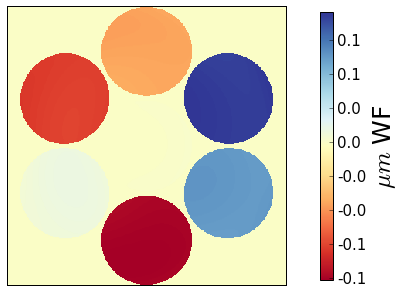

In [84]:
## CLOSE THE LOOP!!
if simul_SPS==True: ps.reset()

for jj in range(totSimulIter):
    tid.tic()
    if simul_SPS==True: gsps.reset()
    if simul_SH==True:  gs.reset()
    if eval_perf_onaxis==True: ongs.reset()

    #----- Update Turbulence --------------------------------------------
    if simul_turb == True:
        if simul_SPS==True:
            atm.ray_tracing(gsps, p,nPx,p,nPx, jj*Tsim)
        if simul_onaxis_AO==True:
            atm.ray_tracing(  gs, p,nPx,p,nPx, jj*Tsim)
        if eval_perf_onaxis==True:
            atm.ray_tracing(ongs, p,nPx,p,nPx, jj*Tsim)
            if eval_perf_modal==True:
                PhaseTur = ongs.phase.host(units='nm')-ph_fda_on*1e3
                seg_aTur_gs_iter[:,:,jj] = Zobj.fitting(PhaseTur)

    #----- Update M1 positions -------------------------------------
    for idx in range(7): gmt.M1.update(origin =  M1TrVec[idx,:].tolist(),
                                 euler_angles = M1RotVec[idx,:].tolist(),
                                 idx = idx+1)
    #----- Update M2 positions -------------------------------------
    """for idx in range(7): gmt.M2.update(origin =  M2TrVec[idx,:].tolist(),
                                 euler_angles = M2RotVec[idx,:].tolist(),
                                 idx = idx+1)"""
    if simul_onaxis_AO==True:
        if onaxis_AO_modes=='TT':
            gmt.M2.motion_CS.euler_angles[:,0:2] -= myTTest1[2:].reshape((7,2))
            gmt.M2.motion_CS.update()
            gmt.M2.global_tiptilt(-myTTest1[0],-myTTest1[1])
        elif onaxis_AO_modes=='zernikes':
            gmt.M2.zernike.a[:,z_first_mode:] = -a_M2.reshape((7,-1))
            gmt.M2.zernike.update()


    #----- On-axis WFS measurement and correction -----------------------
    if simul_onaxis_AO==True:
        gmt.propagate(gs)
        wfs.reset()
        wfs.analyze(gs)
        slopevec = wfs.valid_slopes.host().ravel()

        if onaxis_AO_modes=='TT':
            """#--- segment TT correction (on M2)
            M2TTiter[:,:,jj] = M2RotVec[:,0:2]
            myTTest1 = gAO * np.dot(R_M2_TT, slopevec).reshape((7,2))
            M2RotVec[:,0:2] -= myTTest1"""
            #---- Global TT and Segment TT correction
            M2TTiter[:,:,jj] = M2RotVec[:,0:2]
            M2gTTresiter[:,jj] = -myTTest1[0:2]
            myTTest1 = gAO * np.dot(R_M2_TTm, slopevec)
            M2RotVec[:,0:2] -= myTTest1[2:].reshape((7,2))
            
        #--- segment Zernikes correction (on M2)
        elif onaxis_AO_modes=='zernikes':
            a_M2_iter[:,jj] = a_M2
            a_M2 += gAO * np.dot(R_M2_Z, slopevec)
            
            
    #----- On-axis performance evaluation ---------------------------------
    if eval_perf_onaxis==True:
        gmt.propagate(ongs)
        wfe_gs_iter[jj] = ongs.wavefront.rms()
        seg_pist_onaxis_iter[:,jj] = ongs.piston(where='segments', units_exponent=-9) - seg_pist_onaxis_ref

        if eval_perf_modal==True:
            PhaseRes = ongs.phase.host(units='nm')-ph_fda_on*1e3
            seg_aRes_gs_iter[:,:,jj] = Zobj.fitting(PhaseRes)

            
    #----- Segment Piston Sensors measurement and correction -------------
    if simul_SPS==True:
        gmt.propagate(gsps)
        
        if eval_perf_sps==True:
            seg_pist_sps_iter[:,:,jj] = gsps.piston(where='segments', units_exponent=-9) - seg_pist_sps_ref
                
        if sps_sampl_count == 0 and sps_exp_delay_count < sps_exp_delay_count_max:
            sps_exp_delay_count += 1
            #print("SPS frame avoided at %3.1f ms"%((jj+1)*Tsim*1e3))
        else: ps.propagate(gsps)

        if sps_exp_count == sps_exp_count_max-1:

            #--- Read-out the detector
            if simul_phot==True:
                if simul_bkgd==False:
                    ps.camera.readOut(exposureTime,RONval)
                else: ps.readOut(exposureTime,RONval,bkgd_mag)
            
            #--- Compute and integrate FFTlet images:
            ps.fft()
            ps.camera.reset()
            sps_exp_count = 0
            #print("SPS exposure completed at %3.1f ms"%((jj+1)*Tsim*1e3))

            #--- Compute SPS signals:
            if sps_sampl_count == sps_sampl_count_max-1:
                ps.process()
                SPSmeas = ps.measurement - SPSmeas_ref

                #--- segment piston AND FDSP control:
                if simul_PS_control==True and simul_FDSP_control==True:
                    PISTvec = np.dot(R_PIST, SPSmeas)
                    myPSest1 = gPS * PISTvec[0:6]
                    M1TrVec[0:6,2] -= myPSest1
                    M1PSresiter[:,kk]   = M1TrVec[:,2]
                    myFDSPest1 = gFDSP * PISTvec[6:].reshape((6,2))
                    M1RotVec[0:6,0:2] -= myFDSPest1
                    M1TTresiter[:,:,kk] = M1RotVec[:,0:2]

                #--- ONLY segment piston control:
                elif simul_PS_control==True:
                    PISTvec = np.dot(R_M1_PS, SPSmeas)
                    myPSest1 = gPS * PISTvec
                    M1TrVec[0:6,2] -= myPSest1
                    M1PSresiter[:,kk]   = M1TrVec[:,2]

                #--- ONLY FDSP control:
                elif simul_FDSP_control==True:
                    PISTvec = np.dot(R_FDSP, SPSmeas)
                    myFDSPest1 = gFDSP * PISTvec.reshape((6,2))
                    M1RotVec[0:6,0:2] -= myFDSPest1
                    M1TTresiter[:,:,kk] = M1RotVec[:,0:2]

                if simul_PS_control==True:
                    sys.stdout.write("seg piston RMS [microns]: %0.3f"%(np.std(M1PSresiter[:,kk])*1e6))

                ps.fftlet.reset()
                sps_sampl_count = 0
                sps_exp_delay_count = 0
                kk += 1
                #print("SPS command applied at %3.1f ms"%((jj+1)*Tsim*1e3))
            else: sps_sampl_count += 1
        else: sps_exp_count += 1

    tid.toc()
    elapsedTime[jj] = tid.elapsedTime
    sys.stdout.write("\r iter: %d/%d, ET: %.2f"%(jj, totSimulIter, tid.elapsedTime))
    sys.stdout.flush()                    

if VISU == True:
    ongs.reset()
    gmt.propagate(ongs)
    fig, ax = plt.subplots()
    fig.set_size_inches(20,5)
    imm = ax.imshow(ongs.phase.host(units='micron'), interpolation='None',cmap='RdYlBu',origin='lower')#, vmin=-8, vmax=8)
    ax.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off',
                   right='off', left='off', labelleft='off')
    clb = fig.colorbar(imm, ax=ax, fraction=0.012, pad=0.03,format="%.1f")
    clb.set_label('$\mu m$ WF', fontsize=25)
    clb.ax.tick_params(labelsize=15)
    ongs.reset()

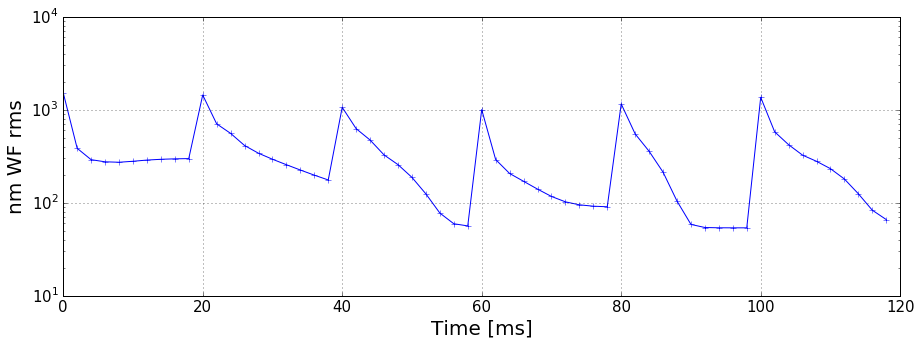

In [85]:
#### on-axis WFE vs. iteration number
if VISU == True and eval_perf_onaxis==True:
    fig, ax = plt.subplots()
    fig.set_size_inches(15,5)
    ax.semilogy(timeVec*1e3, wfe_gs_iter*1e9, '-+')
    ax.grid()
    ax.set_xlabel('Time [ms]', fontsize=20)
    ax.set_ylabel('nm WF rms', fontsize=20)
    ax.tick_params(labelsize=15)

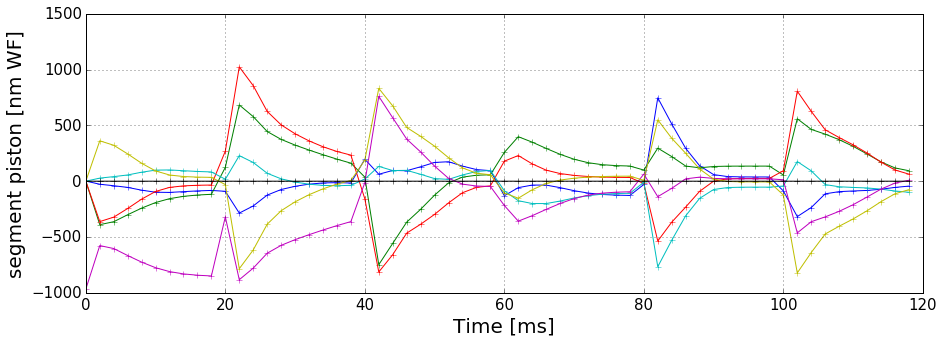

In [86]:
#### on-axis segment WFE vs. iteration number
if VISU == True and eval_perf_onaxis==True:
    fig, ax = plt.subplots()
    fig.set_size_inches(15,5)
    ax.plot(timeVec*1e3, seg_pist_onaxis_iter.T, '-+')
    ax.grid()
    ax.set_xlabel('Time [ms]', fontsize=20)
    ax.set_ylabel('segment piston [nm WF]', fontsize=20)
    ax.tick_params(labelsize=15)


Final M1 final piston (Tz) values [nm WF]:
[  40.456 -238.431 -215.152  115.379  128.398  206.984    0.   ]
-----
Final M2 final piston (Tz) values [nm WF]:
[  -5.749 -141.73  -135.98     5.751  141.732  135.982    0.001]


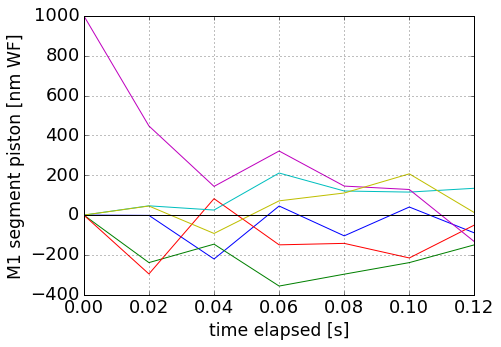

In [87]:
#### Residual segment piston analysis
print 'Final M1 final piston (Tz) values [nm WF]:'
print np.array_str(gmt.M1.motion_CS.origin[:,2]*1e9*2, precision=3, suppress_small=True)
print '-----'
print 'Final M2 final piston (Tz) values [nm WF]:'
print np.array_str(gmt.M2.motion_CS.origin[:,2]*1e9*2, precision=3, suppress_small=True)

if VISU == True and simul_PS_control==True:
    timeCorVec = np.arange(sps_sampl_iter+1)*samplingTime
    f1, ax1 = plt.subplots()
    f1.set_size_inches(7,5)
    ax1.plot(timeCorVec, M1PSresiter.T *1e9*2, label='S')
    ax1.grid()
    #ax1.set_title('Tz', size='x-large')
    ax1.set_xlabel('time elapsed [s]', size='xx-large')
    ax1.set_ylabel('M1 segment piston [nm WF]', size='xx-large')
    ax1.tick_params(labelsize=18)
    #ax1.legend()
    """initpos = 11
    deltapos = 2
    plt.text(initpos,11,'S1', color='b', ha='center', fontsize=18)
    plt.text(initpos+deltapos,11,'S2', color='g', ha='center', fontsize=18)
    plt.text(initpos+2*deltapos,11,'S3', color='r', ha='center', fontsize=18)
    plt.text(initpos+3*deltapos,11,'S4', color='c', ha='center', fontsize=18)
    plt.text(initpos+4*deltapos,11,'S5', color='m', ha='center', fontsize=18)
    plt.text(initpos+5*deltapos,11,'S6', color='y', ha='center', fontsize=18)
    plt.text(initpos+6*deltapos,11,'S7', color='k', ha='center', fontsize=18)"""

------
Final M2 final TT (Rx, Ry) values [mas]:
[  27.748   21.697 -628.618  323.071 -234.18  -364.176    0.686]
[-244.938 -558.263 -383.289  -10.643  554.815 -463.193  -19.782]
------
Final M1 final TT (Rx, Ry) values [mas]:
[  3.423   0.662 -80.681  40.602 -27.347 -43.645   0.   ]
[-28.393 -69.062 -49.464  -3.733  68.634 -56.964   0.   ]


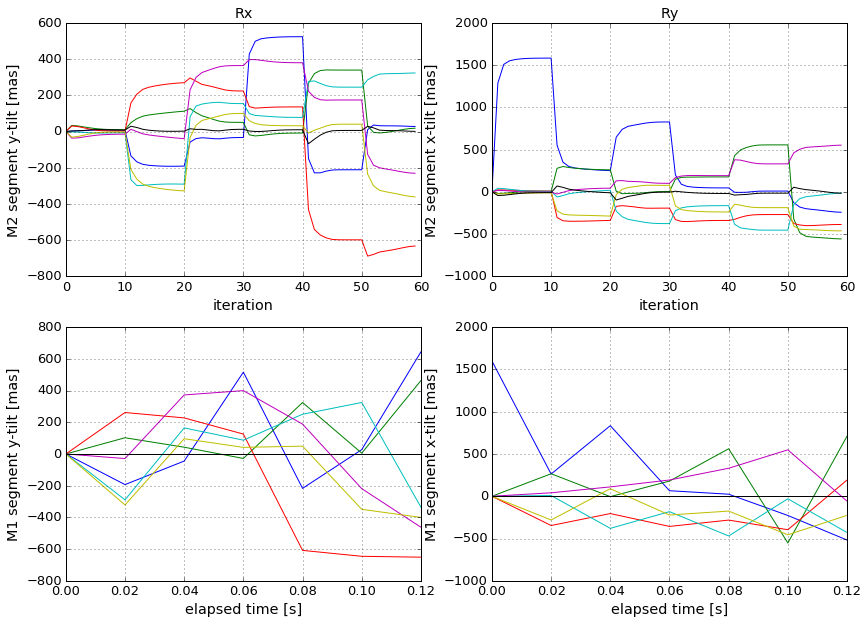

In [88]:
#### Residual M1 / M2 segment Tip-tilt analysis

print '------'
print 'Final M2 final TT (Rx, Ry) values [mas]:'
print np.array_str(gmt.M2.motion_CS.euler_angles[:,0]*ceo.constants.RAD2MAS, precision=3, suppress_small=True)
print np.array_str(gmt.M2.motion_CS.euler_angles[:,1]*ceo.constants.RAD2MAS, precision=3, suppress_small=True)
print '------'
print 'Final M1 final TT (Rx, Ry) values [mas]:'
print np.array_str(gmt.M1.motion_CS.euler_angles[:,0]*ceo.constants.RAD2MAS, precision=3, suppress_small=True)
print np.array_str(gmt.M1.motion_CS.euler_angles[:,1]*ceo.constants.RAD2MAS, precision=3, suppress_small=True)

if VISU == True:
    #f1, (ax3,ax4) = plt.subplots(ncols=2)
    f1, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
    ax1.axis('auto')
    ax2.axis('auto')
    ax3.axis('auto')
    ax4.axis('auto')
    f1.set_size_inches(14,10)

    ax1.plot(M2TTiter[:,0,:].T * ceo.constants.RAD2MAS)
    ax1.grid()
    ax1.set_title('Rx', size='x-large')
    ax1.set_xlabel('iteration', size='x-large')
    ax1.set_ylabel('M2 segment y-tilt [mas]', size='x-large')
    ax1.tick_params(labelsize=13)

    ax2.plot(M2TTiter[:,1,:].T *ceo.constants.RAD2MAS)
    ax2.grid()
    ax2.set_title('Ry', size='x-large')
    ax2.set_xlabel('iteration', size='x-large')
    ax2.set_ylabel('M2 segment x-tilt [mas]', size='x-large')
    ax2.tick_params(labelsize=13)

    ax3.plot(timeCorVec, M1TTresiter[:,0,:].T *ceo.constants.RAD2MAS*8)
    ax3.grid()
    #ax3.set_title('Rx', size='x-large')
    ax3.set_xlabel('elapsed time [s]',size='x-large')
    ax3.set_ylabel('M1 segment y-tilt [mas]', size='x-large')
    ax3.tick_params(labelsize=13)

    ax4.plot(timeCorVec, M1TTresiter[:,1,:].T *ceo.constants.RAD2MAS*8)
    ax4.grid()
    #ax4.set_title('Ry', size='x-large')
    ax4.set_xlabel('elapsed time [s]', size='x-large')
    ax4.set_ylabel('M1 segment x-tilt [mas]', size='x-large')
    ax4.tick_params(labelsize=13)

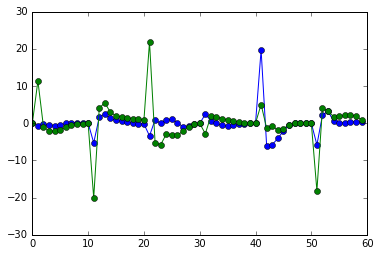

In [89]:
plt.plot(M2gTTresiter.T*ceo.constants.RAD2MAS, 'o-')

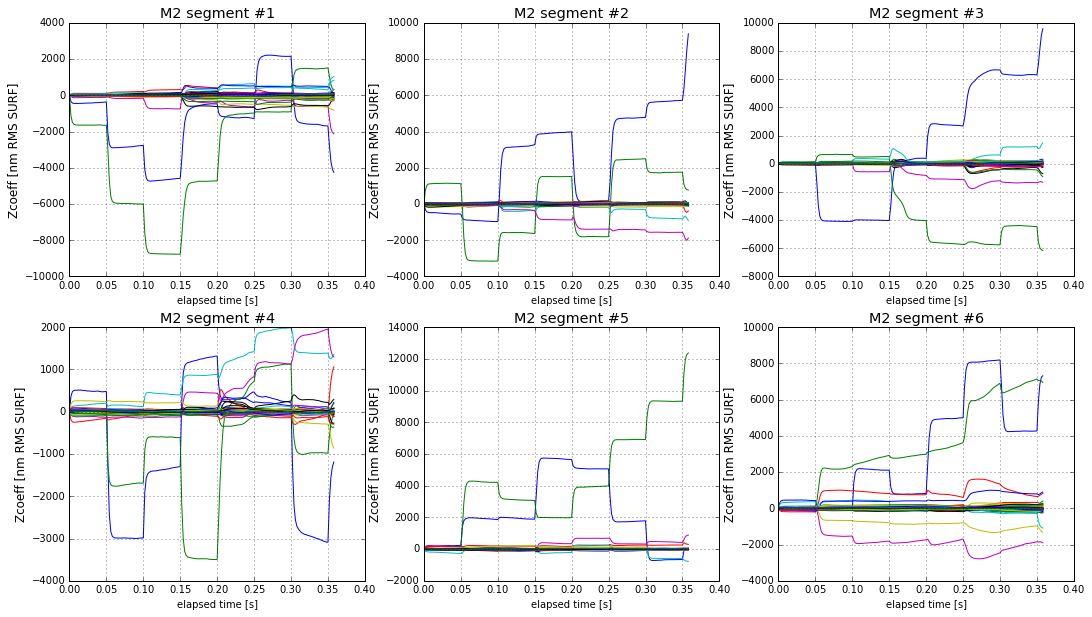

In [40]:
#### Residual M2 segment Zernikes
if VISU == True:
    my_a_M2 = (a_M2_iter.reshape((7,-1,totSimulIter)))
    f1, ax = plt.subplots(ncols=3, nrows=2)
    f1.set_size_inches(18,10)
    for jj in range(6):
        thisax = (ax.ravel())[jj]
        thisax.plot(timeVec, my_a_M2[jj,:,:].T*1e9)
        thisax.grid()
        thisax.set_title('M2 segment #%d'%(jj+1), size='x-large')
        thisax.set_xlabel('elapsed time [s]')
        thisax.set_ylabel('Zcoeff [nm RMS SURF]', size='large')

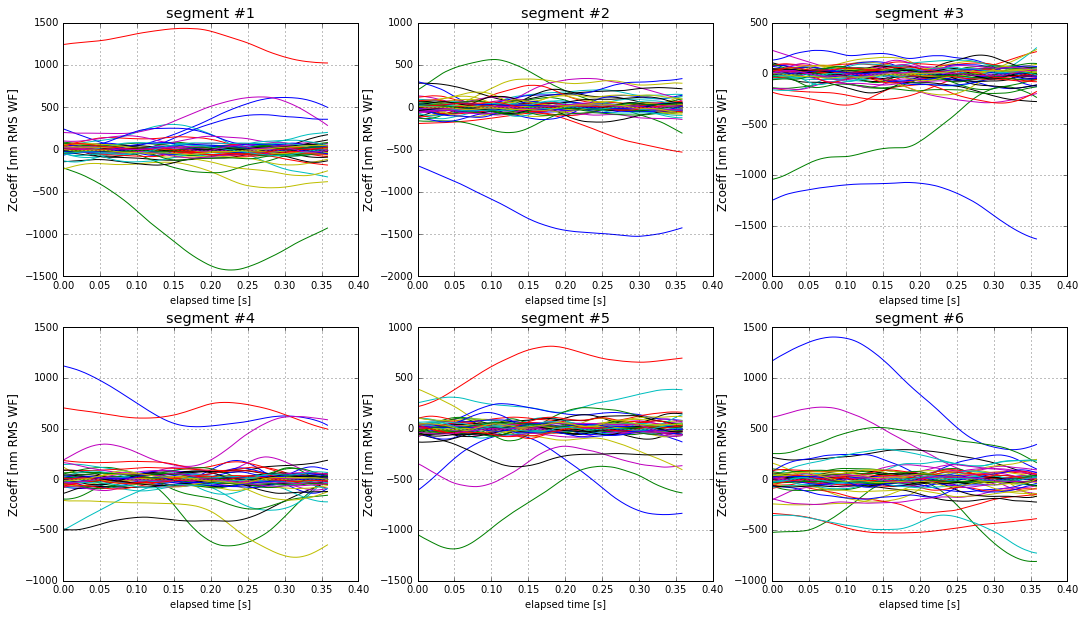

In [43]:
#### Turb segment Zernikes
if VISU == True:
    f1, ax = plt.subplots(ncols=3, nrows=2)
    f1.set_size_inches(18,10)
    for jj in range(6):
        thisax = (ax.ravel())[jj]
        thisax.plot(timeVec, seg_aTur_gs_iter[:,jj,:].T, label='Z')
        thisax.grid()
        thisax.set_title('segment #%d'%(jj+1), size='x-large')
        thisax.set_xlabel('elapsed time [s]')
        thisax.set_ylabel('Zcoeff [nm RMS WF]', size='large')
        #thisax.legend()

NameError: name 'seg_aRes_gs_iter' is not defined

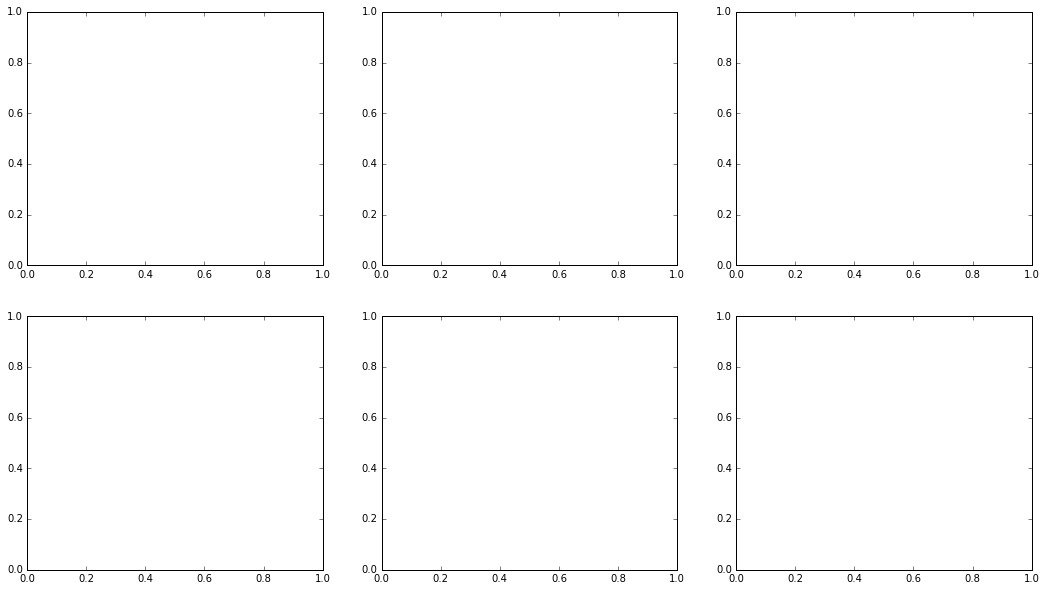

In [40]:
#### Residual segment Zernikes
if VISU == True:
    f1, ax = plt.subplots(ncols=3, nrows=2)
    f1.set_size_inches(18,10)
    for jj in range(6):
        thisax = (ax.ravel())[jj]
        thisax.plot(timeVec, seg_aRes_gs_iter[:,jj,:].T, label='Z')
        thisax.grid()
        thisax.set_title('segment #%d'%(jj+1), size='x-large')
        thisax.set_xlabel('elapsed time [s]')
        thisax.set_ylabel('Zcoeff [nm RMS WF]', size='large')
        #thisax.legend()

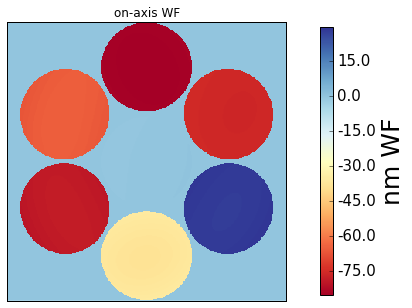

In [41]:
### Show final on-axis residual WF
if VISU == True:
    ongs.reset()
    gmt.propagate(ongs)
    fig, ax = plt.subplots()
    fig.set_size_inches(20,5)
    imm = ax.imshow(ongs.phase.host(units='nm')-ph_fda_on*1e3, interpolation='None',cmap='RdYlBu', origin='lower')#, vmin=-1.5, vmax=1.5)
    ax.set_title('on-axis WF')
    ax.tick_params(axis='both', which='both', bottom='off', top='off', labelbottom='off', right='off', left='off', labelleft='off')
    clb = fig.colorbar(imm, ax=ax, fraction=0.012, pad=0.03,format="%.1f")
    clb.set_label('nm WF', fontsize=25)
    clb.ax.tick_params(labelsize=15)

In [46]:
"""#### Compute residual WFE in the Field
sfgs.reset()
gmt.propagate(sfgs)
sf_rms = sfgs.wavefront.rms()*1e9

if VISU == True:
    fig,ax = plt.subplots()
    fig.set_size_inches((5,4))
    contp = ax.contourf(sfx, sfy, sf_rms.reshape(len(sfx),-1))
    #contp = ax.imshow(sf_rms.reshape(len(sfx),-1), extent=[-45, 45, -45, 45], origin='lower', interpolation='bilinear')
    clb = fig.colorbar(contp, ax=ax)
    ax.grid()
    ax.tick_params(labelsize=12)
    ax.set_xlabel('field angle [arcsec]', fontsize=15)
    clb.set_label('nm WF RMS', fontsize=15)
    clb.ax.tick_params(labelsize=12)

print '--> WF RMS on-axis: %3.2f nm wf RMS'%on_rms
print '--> max WF RMS at the edge of the field: %3.2f nm WF RMS'%np.max(sf_rms)"""

"#### Compute residual WFE in the Field\nsfgs.reset()\ngmt.propagate(sfgs)\nsf_rms = sfgs.wavefront.rms()*1e9\n\nif VISU == True:\n    fig,ax = plt.subplots()\n    fig.set_size_inches((5,4))\n    contp = ax.contourf(sfx, sfy, sf_rms.reshape(len(sfx),-1))\n    #contp = ax.imshow(sf_rms.reshape(len(sfx),-1), extent=[-45, 45, -45, 45], origin='lower', interpolation='bilinear')\n    clb = fig.colorbar(contp, ax=ax)\n    ax.grid()\n    ax.tick_params(labelsize=12)\n    ax.set_xlabel('field angle [arcsec]', fontsize=15)\n    clb.set_label('nm WF RMS', fontsize=15)\n    clb.ax.tick_params(labelsize=12)\n\nprint '--> WF RMS on-axis: %3.2f nm wf RMS'%on_rms\nprint '--> max WF RMS at the edge of the field: %3.2f nm WF RMS'%np.max(sf_rms)"

In [48]:
#---- Dictionary containing variables to save in results file
tosave = dict(D=D, nPx=nPx, Tsim=Tsim, totSimulTime=totSimulTime, simul_turb=simul_turb,
        simul_onaxis_AO=simul_onaxis_AO, simul_PS_control=simul_PS_control,
        simul_FDSP_control=simul_FDSP_control, M1_radial_order=M1_radial_order, M2_radial_order=M2_radial_order,
        elapsedTime=elapsedTime, scramble_tt=scramble_tt, scramble_pist=scramble_pist)

if simul_turb == True:
    tosave.update(dict(r0=r0, L0=L0, atm_fname=atm_fname, atm_seed=atm_seed))

if simul_SPS == True:
    tosave.update(dict(band=band, mag=mag, bkgd_mag=bkgd_mag,sps_fov=sps_fov, sps_dispersion=sps_dispersion,
        sps_mask_size=sps_mask_size,RONval=RONval, sps_seed=sps_seed, simul_phot=simul_phot, simul_bkgd=simul_bkgd,
        SPSmeas_ref=SPSmeas_ref, exposureTime=exposureTime, samplingTime=samplingTime, N_GS_PS=N_GS_PS,
        alpha_ps=alpha_ps, throughput=throughput, lobe_detection=lobe_detection, nyquist_factor=nyquist_factor,
        CL_calib_modes=CL_calib_modes, sps_sampl_iter=sps_sampl_iter))
    if eval_perf_sps == True: tosave['seg_pist_sps_iter']=seg_pist_sps_iter

if simul_SH == True:
    tosave.update(dict(sh_SA=nLenslet, sh_npix=n, sh_thr=sh_thr, sh_fov=sh_fov))

if simul_onaxis_AO == True:
    tosave.update(dict(gAO=gAO, onaxis_AO_modes=onaxis_AO_modes))
    if onaxis_AO_modes == 'zernikes': tosave['a_M2_iter'] = a_M2_iter
    elif onaxis_AO_modes =='TT':
        tosave['M2TTiter'] = M2TTiter
        tosave['M2gTTresiter']=M2gTTresiter

if simul_PS_control == True:
    tosave.update(dict(gPS=gPS, PS_CL_calib=PS_CL_calib, M1PSresiter=M1PSresiter))

if simul_FDSP_control == True:
    tosave.update(dict(gFDSP=gFDSP, remove_on_pist=remove_on_pist, M1TTresiter=M1TTresiter))

if eval_perf_onaxis == True:
    tosave.update(dict(wfe_gs_iter=wfe_gs_iter, seg_pist_onaxis_iter=seg_pist_onaxis_iter))

if eval_perf_modal == True:
    tosave['seg_aRes_gs_iter']=seg_aRes_gs_iter
    if simul_turb == True: tosave['seg_aTur_gs_iter']=seg_aTur_gs_iter

if scramble_tt == True:
    tosave.update(dict(tt_scramble_rms=tt_scramble_rms, TTscramble=TTscramble))

if scramble_pist == True:
    tosave.update(dict(pist_scramble_rms=pist_scramble_rms, pistscramble=pistscramble))

#---- Save the results file!
now = datetime.datetime.now()

save_dir = './'
#filename=save_dir+'SPS'+str(int(alpha_ps/60))+'_'+clcalib+'_mag'+str(int(mag))+'_Turb'+str(atm_seed)+'_Noise'+str(sps_seed)+'_Texp'+str(int(exposureTime*1e3))+'ms'+'_Ts'+str(int(samplingTime*1e3))+'ms.npz'

filename=save_dir+now.strftime("%Y%m%d-%H%M")+'.npz'
np.savez_compressed(filename, **tosave)

In [49]:
print filename

./20160603-0015.npz
